## Comparison of Annotators

In [1]:
# Import basic packages
import numpy as np 
import scipy as scipy 
import os
import sys
import json
import datetime
from PIL import Image
import skimage.draw
import numpy.ma as ma
import imageio

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [2]:
# Common core
common_cores = ["common_core_Dimitrios.json","common_core_AlexC.json","common_core_AlexDW.json","common_core_Ariel.json",
        "common_core_Sydney.json","common_core_diana.json","common_core_jackie.json","common_core_kathryn.json"]

n_annots = len(common_cores) # Number of annotators

# Let's print the number of annotators
print(n_annots)

8


In [3]:
# Define function that creates mask for the Ghosts
def masking(regions,n_ghosts):
    
    """
    Inputs:

    Outputs:

    """
    #Initialize three different masks - one for each type of ghosts
    X_mask_rays = np.zeros([400,400])
    X_mask_bright = np.zeros([400,400])
    X_mask_faint = np.zeros([400,400])

    for k in range(n_ghosts):
        regions_loc = regions[k]

        # ==========================================
        # ==========================================
        # First get ghost types
        Type_loc = regions_loc['region_attributes']['Type']

        # Get shape attributes
        shape_attrs = regions_loc['shape_attributes']

        # Get the name of the shape attribute
        name = shape_attrs['name']
        # =====================================================
        # =====================================================
    
        if (name=='polyline'):
            rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
            a = (rr<400)&(cc<400)
        elif (name=='polygon'):
            rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
            a = (rr<400)&(cc<400)
        elif (name=='rect'):
            rr, cc = skimage.draw.rectangle(start=(shape_attrs['y'], shape_attrs['x']),
                              extent=(shape_attrs['height'],shape_attrs['width']))
            a = (rr<400)&(cc<400)
        elif (name=='circle'):
            rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])
            a = (rr<400)&(cc<400)
        elif (name=='ellipse'): 
            rr, cc = skimage.draw.ellipse(shape_attrs['cy'],shape_attrs['cx'],
                                      shape_attrs['ry'],shape_attrs['rx'],
                                      shape=None,rotation=-shape_attrs['theta'])
            a = (rr<400)&(cc<400)
        # ========================================================
        # ========================================================
        if (Type_loc=='Rays'):
            X_mask_rays[rr[a], cc[a]] = 1.
        elif (Type_loc=='Bright'):
            X_mask_bright[rr[a], cc[a]] = 1.
        elif (Type_loc=='Faint'):
            X_mask_faint[rr[a], cc[a]] = 1.

        # ===========================================================
        
  
    # We return the 2D arrays now
    return X_mask_rays, X_mask_bright, X_mask_faint

In [4]:
# Initialize matrices
X_rays_tot = np.zeros([50,400,400]) # For Rays
X_bright_tot = np.zeros([50,400,400]) # For bright
X_faint_tot = np.zeros([50,400,400]) # For faint


# Run over annotators
for i in range(n_annots):
    # Annotator i
    common_core_local = common_cores[i]
    
    #print(common_core_local)
    # =================================
    # Load annotations
    
    annotations_loc = json.load(open(common_core_local))
    annotations = list(annotations_loc['_via_img_metadata'].values())
    annotations = [a for a in annotations if a['regions']]
   
    # ================================
    # Print the number of images
    n_img = len(annotations)
    
    # =======================================================
    # =======================================================
    # Run over images
    for j in range(n_img):
        # Get the annotations of the j-th image
        img_annotations = annotations[j]
        
        # Get regions - pretty much the description of the annotations
        regions = img_annotations['regions']
        # Now get the number of ghosts
        n_ghosts = len(regions)
        
        # Get rays, bright, faint masks - pretty much "1" in the spots
        # where there is a ghost
        X_rays, X_bright, X_faint = masking(regions,n_ghosts)
        
        # Update the matrices
        X_rays_tot[j,:,:] += X_rays
        X_bright_tot[j,:,:] += X_bright
        X_faint_tot[j,:,:] += X_faint
    
    
    

<ipython-input-3-ea2aef869751>:42: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])


In [5]:
X_rays_flat = X_rays_tot.flatten()
X_bright_flat = X_bright_tot.flatten()
X_faint_flat = X_faint_tot.flatten()

print(np.max(X_faint_flat))

8.0


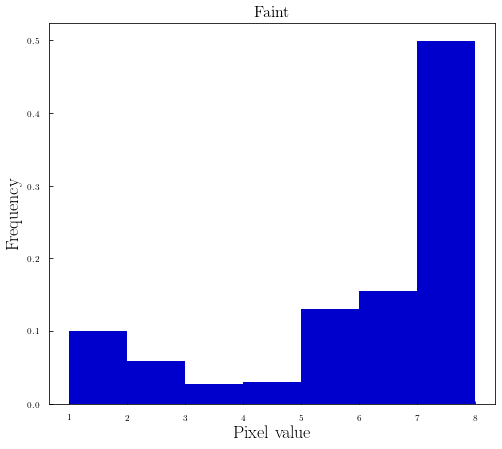

In [69]:
bins_def = [1,2,3,4,5,6,7,8]

plt.figure(figsize=(8, 7))


plt.hist(X_faint_flat[X_faint_flat>0],bins=bins_def,color='mediumblue',density=True)
plt.title('Faint',fontsize=16)

plt.xlabel("Pixel value", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.savefig('Faint_dist.pdf')
plt.show()

### Image of first image

In [51]:
annotations_loc = json.load(open("common_core_Dimitrios.json"))
annotations = list(annotations_loc['_via_img_metadata'].values())
annotations = [a for a in annotations if a['regions']]

i = 40
img_annotations = annotations[i]
# Get filename
filename = img_annotations['filename']
# Get image 
image = Image.open(filename)

In [52]:
X_mask_rays = ma.masked_where(X_rays_tot[i,:,:]<1, X_rays_tot[i,:,:])
X_mask_bright = ma.masked_where(X_bright_tot[i,:,:]<1, X_bright_tot[i,:,:])
X_mask_faint = ma.masked_where(X_faint_tot[i,:,:]<1, X_faint_tot[i,:,:])

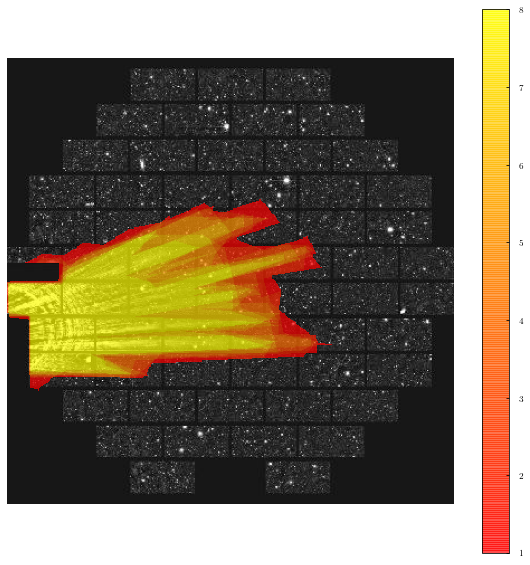

In [70]:
plot_pretty() 
plt.figure(figsize=(10, 10))

plt.imshow(image,cmap='gray')

plt.imshow(X_mask_rays,cmap='autumn',alpha=0.7)
#plt.imshow(X_mask_bright,cmap='Wistia',alpha=0.5)
#plt.imshow(X_mask_faint,cmap='winter',alpha=0.5)

plt.colorbar()


plt.axis('off')
plt.savefig('Overlap.pdf')
plt.show()